*Parameter cells and Devices cells must be executed for any of the sections:
The sections of cells that must be executed are marked by  an astherisk as *

# Parameters*

In [1]:
if "google.colab" in str(get_ipython()):
    %pip install --quiet git+https://github.com/loganbvh/py-tdgl.git
    !apt install ffmpeg

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 595.3/595.3 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 306.8/306.8 kB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.3/252.3 kB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 85.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.7/76.7 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.8/59.8 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 66.5 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.


In [2]:
from tdgl.visualization.animate import create_animation
from IPython.display import HTML, display
from IPython.display import clear_output
from tdgl.sources import ConstantField
from tdgl.geometry import box, circle
import matplotlib.pyplot as plt
import numpy as np
import tempfile
import h5py
import tdgl
import time
import os



/usr/local/lib/python3.12/dist-packages/cupyx/jit/_interface.py:173: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')


In [3]:
# ====================================================
# Default configuration
# ====================================================
os.environ["OPENBLAS_NUM_THREADS"] = "1"
MAKE_ANIMATIONS = True
tempdir = tempfile.TemporaryDirectory()
length_units = "um"
H5_DIR = "./project_field_h5_files"
os.makedirs(H5_DIR, exist_ok=True)
os.environ["OPENBLAS_NUM_THREADS"] = "1"
# Configuración de gráficas
plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams.update({'figure.autolayout': True})
plt.rcParams['lines.linewidth'] = 2.0


# PARAMETERS AND FUNCTIONS*

In [4]:
###################################################################
#This script contains the default parameters and functions used in the notebook.#
###################################################################
# ====================================================
## 1. ⚙️ Global Parameters(Optimized)
# ====================================================

### 1.1. Material parameters
LENGTH_UNITS = "um"
xi = 0.5
london_lambda = 2
d = 0.1
gamma = 10
  # Ancho del puente (dimensión x)
 # Alto del puente (dimensión y)

STRIPE_LENGTH = 0.01   # side of the square contact
OVERLAP = 0.5         # aditional space for overlapping


### 1.3. Parámetros de Malla
MAX_EDGE_LENGTH_IV = xi / 1.5
MAX_EDGE_LENGTH_VORTEX = xi / 1.5
SMOOTHING_STEPS = 100

# ====================================================
## 2. ⚙️ videos and default functions
# ====================================================
os.environ["OPENBLAS_NUM_THREADS"] = "1"
MAKE_ANIMATIONS = True
tempdir = tempfile.TemporaryDirectory()
def make_video_from_solution(
    solution,
    quantities=("order_parameter", "phase"),
    fps=20,
    figsize=(5, 4),
):
    """Generates an HTML5 video from a tdgl.Solution."""
    with tdgl.non_gui_backend():
        with h5py.File(solution.path, "r") as h5file:
            anim = create_animation(
                h5file,
                quantities=quantities,
                fps=fps,
                figure_kwargs=dict(figsize=figsize),
            )
            video = anim.to_html5_video()
        return HTML(video)
def default_options(d_filename,skip_t=200,solve_t=200,saves=200):
    options =  tdgl.SolverOptions(
    skip_time=skip_t,  # initial relaxation time
    solve_time=solve_t,  # Real simulation time
    output_file=os.path.join(tempdir.name,d_filename),  # file route
    field_units="mT",  #Units of the applied field (miliTesla)
    current_units="uA",  # Units of the applied current (microamperios)
    save_every=saves,
    )
    return options

def default_solution(device,file_name,vector_potential=0,terminal_currents_applied=[0,0]):
    '''
    This function allows the user to apply different solution cases based on the applied current/field
    device: tdgl.device object
    type_of_solution: String
    vector_potential: Double
    terminal_currents: unidimensional array [source_current,drain_current]
    Depending on the type_of_solution a solution is implemented
    '''
    options = default_options(file_name)
    external_field = ConstantField(vector_potential, field_units=options.field_units, length_units=device.length_units)
    solution = tdgl.solve(
         device,
         options,
         terminal_currents= dict(source=terminal_currents_applied[0],drain=terminal_currents_applied[1]),
         applied_vector_potential=external_field
        )
    return solution
# ====================================================
# 3.)Default configuration
# ====================================================
H5_DIR = "./project_field_h5_files"
os.makedirs(H5_DIR, exist_ok=True)
os.environ["OPENBLAS_NUM_THREADS"] = "1"
# Configuración de gráficas
plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams.update({'figure.autolayout': True})
plt.rcParams['lines.linewidth'] = 2.0
# ====================================================
# 4.)Device Creation Function
# ====================================================
def plot_parameters(p1,p2,plot_labels,plot_type="plot",color_applied="teal"):
    plt.figure(figsize=(6, 4))
    if plot_type == "plot":
        plt.plot(p1,p2, "o-", color=color_applied)
    elif plot_type == "scatter":
        plt.scatter(p1,p2, "o-", color=color_applied)
    else:
        print("insert a valid plot type")
        return None
    plt.xlabel(plot_labels["x"])
    plt.ylabel(plot_labels["y"])
    plt.title(plot_labels["title"])
    plt.grid(True)
    plt.show()
    plt.savefig(plot_labels["fig_name"])
# ====================================================
## 4. ⚙️ Global Parameters(Optimized)
# ====================================================

def create_device(geometry_used,geometry_added,layer,max_edge_length,dimensions,translationx=0,incrementx=0.0,incrementy=0.0,translationy=0):
    '''
    Since we're using the same geometry, this function is implemented so we can change the dimensions of the right rectangle hence the position of the drain too : tdgl.polygon object,
    geometry_used: tdgl.polygon object,
    geometry_added: tdgl.polygon object,
    max_edge_length:int,
    incrementx:float
    incrementy:float
    source_dimension: array [width,height]
    drain_dimension: array [width,height]
    translationx:float
    translationy:float
    The translations move the source and drain along the polygon
    '''
    width_x = dimensions['width_x']
    height_y = dimensions['height_y']
    width_x2 = dimensions['width_x2']
    height_y2 = dimensions['height_y2']
    #for points that are the same as the  film width
    contact_size = width_x #1 µm squares
    real_size_x = width_x2 + incrementx
    real_size_y =3 + incrementy
    film_poly_up = tdgl.Polygon("film_pequeño", points=box(width=real_size_x, height= real_size_y)).translate(dx=+width_x/2)
    combined_geometry = geometry_used.union(geometry_added,film_poly_up)
    #Source
    source_poly = tdgl.Polygon(
        "source",
        points=box(width=STRIPE_LENGTH,height=height_y2)
    ).translate(dx=-translationx).translate(dy=translationy)
    #Drain
    drain_poly = tdgl.Polygon(
        "drain",
        points=box(width=STRIPE_LENGTH, height=real_size_y)
    ).translate(dx=+translationx+incrementx/2).translate(dy=+translationy)
    combined_film = tdgl.Polygon.from_union([combined_geometry, source_poly, drain_poly], name="film")
    probe_points = [(width_x / 3,0), (-width_x / 3,0)]
    device = tdgl.Device(
        "vertical_bridge",
        layer=layer,
        film=combined_film,
        holes=[],
        terminals=[source_poly, drain_poly],
        probe_points=probe_points,
        length_units=LENGTH_UNITS,
    )
    device.make_mesh(max_edge_length=max_edge_length, smooth=SMOOTHING_STEPS)
    #Remove to se more details about the mesh
    #There are 4 malformed cells as of now , 4/5030
    clear_output(wait=True)
    print(f"  Malla creada: {len(device.mesh.sites)} puntos")
    fig, ax = device.draw()
    return device


# =========================
# 5) Magnetization function
# =========================
def solve_field(device,field,d=0.1):
    d = 0.1  # Superconductor depth in micrometers (µm)
    area = np.sum(device.areas)  # effective area of the device ( µm²)
    # =========================
    # 3) External Field sweep
    # =========================
    # Defines a list of 10 values for the external magnetic field form 0 to 1 mT
    moments = [] #total magnetic moment
    magnetizations = []  # volumetric magnetization
    m_solutions = []
    # Loop for each value of B

    with tempfile.TemporaryDirectory() as temp_dir:
        for B in field:
            # Creates a uniform magnetic field of magnitude B
            # Solves Ginzburg–Landau equations with an applied field
            solution_field= default_solution(device,"Bscan.h5",vector_potential=B,terminal_currents_applied=[0.0,0.0])
            #Calculates total magnetic moment (uA · µm²)
            m = solution_field.magnetic_moment(units="uA * um**2", with_units=False)
            moments.append(m)  # Almacena el valor
            # Calculates volumetric magnetization: M = m / (Area ×depth)  in µA / µm³
            M = m / (area * d)
            magnetizations.append(M)

    # =========================
    # 4) Susceptibility dM/dB
    # =========================
    magnetizations = np.array(magnetizations)
    # Numeric derivation of the magnetization with respect to the field: dM/dB
    #suceptibilidad_fast = np.gradient(magnetizaciones_fast, campos_fast)
    # =========================
    # 5)Save data on files
    # =========================
    np.savetxt("magnetization_vs_B.txt", np.column_stack((field, magnetizations)),
               header="B[mT] M[uA/um^3]")
    #np.savetxt("suceptibilidad_rr_vs_B.txt", np.column_stack((campos_rr, suceptibilidad_rr)),
               #header="B[mT] dM/dB [uA/(um^3·mT)]")
    return moments,magnetizations

def current_application(device,currents,B_field = 0):
    voltages = []
    # =========================================================
    # Simulation
    # =========================================================
    start_time = time.time()
    total_simulations = len(currents)
    j=0
    with tempfile.TemporaryDirectory() as temp_dir:
        for I in currents:
            solution_c = default_solution(
            device,
            f"solution_I_{I:.1f}.h5",
            vector_potential=B_field,
            terminal_currents_applied=[I, -I],
           )
            dynamics = solution_c.dynamics
            indices = dynamics.time_slice(tmin=120)
            voltage = np.abs(np.mean(dynamics.voltage()[indices]))
            voltages.append(voltage)
            j+=1
            print(f"I = {I:.1f} µA, <V> = {voltage:.4f} V₀,progress: {np.round(j/np.size(currents)*100,2)}%", end='\r')


    clear_output(wait=True)
    end_time = time.time()
    elapsed_time = end_time - start_time
    elapsed_minutes = elapsed_time/60
    print(" " * 60, end='\r')
    print("-" * 50)
    print(f"✅ The simulation was completed with {total_simulations} steps.")
    print(f"⏱️ The elapsed time was: {elapsed_time:.2f} seconds.")
    print(f"⏱️ The elapsed time was: {elapsed_minutes:.2f} minutes.")
    print(f"📊 Tiempo mean time per step was: {(elapsed_time / total_simulations):.2f} seconds.")
    print("-" * 50)
    return voltages



In [5]:

# ====================================================
## 1. ⚙️ Global Parameters(Optimized)
# ====================================================

###Main rectangle
# Ancho del puente (dimensión x)
width_x = 5.0
# Alto del puente (dimensión y)
height_y = 12.0
STRIPE_LENGTH = 0.01   # side of the square contact
OVERLAP = 0.5         # aditional space for overlapping
###Rectangulo pequeño
width_x2 = width_x/2
height_y2 =(height_y/2)+ 1
dimensions = {"width_x":width_x,"width_x2": width_x/2,"height_y":height_y,"height_y2":height_y2}
### 1.3. Parámetros de Malla
MAX_EDGE_LENGTH_IV = xi / 1.5
MAX_EDGE_LENGTH_VORTEX = xi / 1.5
SMOOTHING_STEPS = 100
# Geometría inicial y capa
film_poly = tdgl.Polygon("film_base", points=box(width=width_x, height=height_y))
film_poly_down = tdgl.Polygon("film_pequeño", points=box(width=width_x2, height=height_y2)).translate(dx=-width_x/2)
half_geometry = film_poly.union(film_poly,film_poly_down)
layer = tdgl.Layer(coherence_length=xi, london_lambda=london_lambda, thickness=d, gamma=gamma)
print(f'widths: width_x:{width_x},width_x2:{width_x2},height_y:{height_y},height_y2:{height_y2},height_y2_altered:{3}' )

widths: width_x:5.0,width_x2:2.5,height_y:12.0,height_y2:7.0,height_y2_altered:3


# Device*

Device and mesh creation

  Malla creada: 2944 puntos


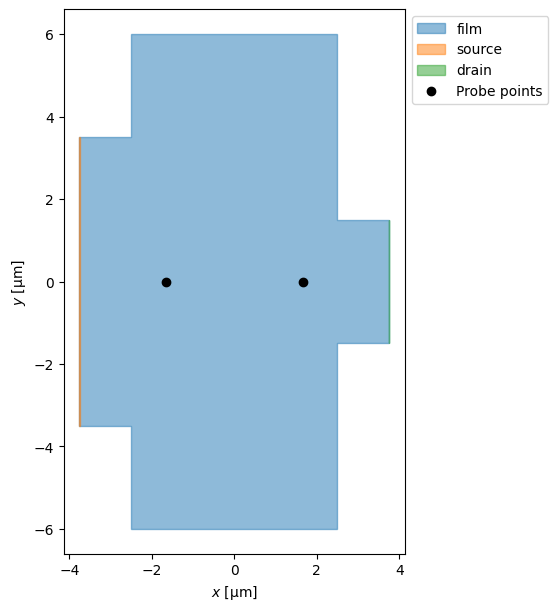

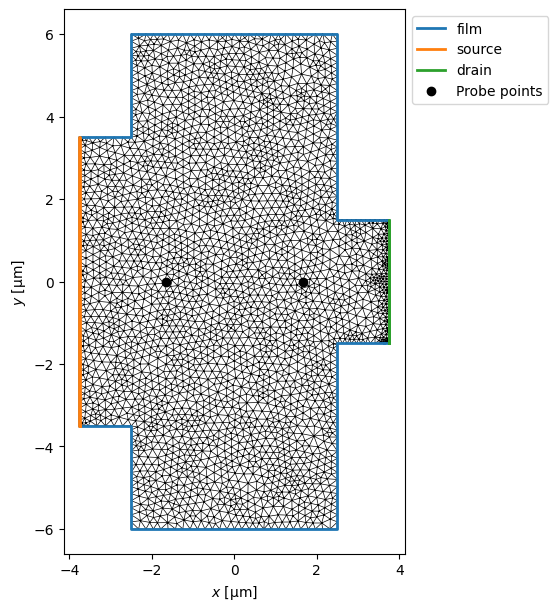

In [6]:
displacement = (width_x + width_x2 + STRIPE_LENGTH) / 2
device_fast = create_device(film_poly,half_geometry,layer,MAX_EDGE_LENGTH_IV,dimensions,translationx=displacement)
fig, ax = device_fast.plot(mesh=True)

# Simulations

## 1) Zero field for a fixed current

In [ ]:
zero_field_solution = default_solution(device_fast,"zero_field_zero_current.h5",terminal_currents_applied=[28,-28])

Simulating: 100%|██████████| 200/200 [01:04<00:00,  3.11tau/s ]


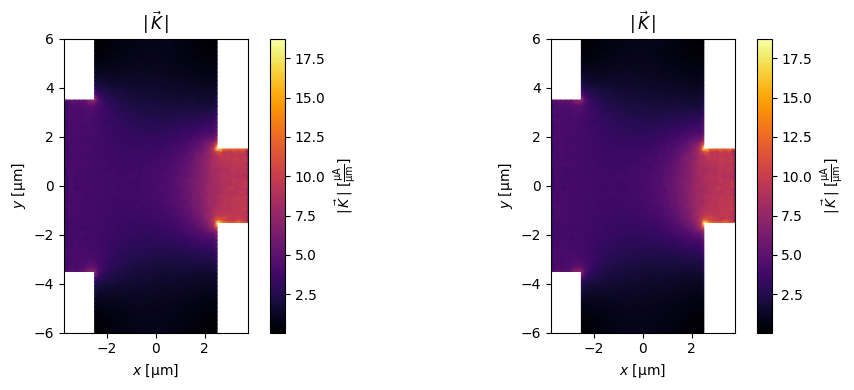

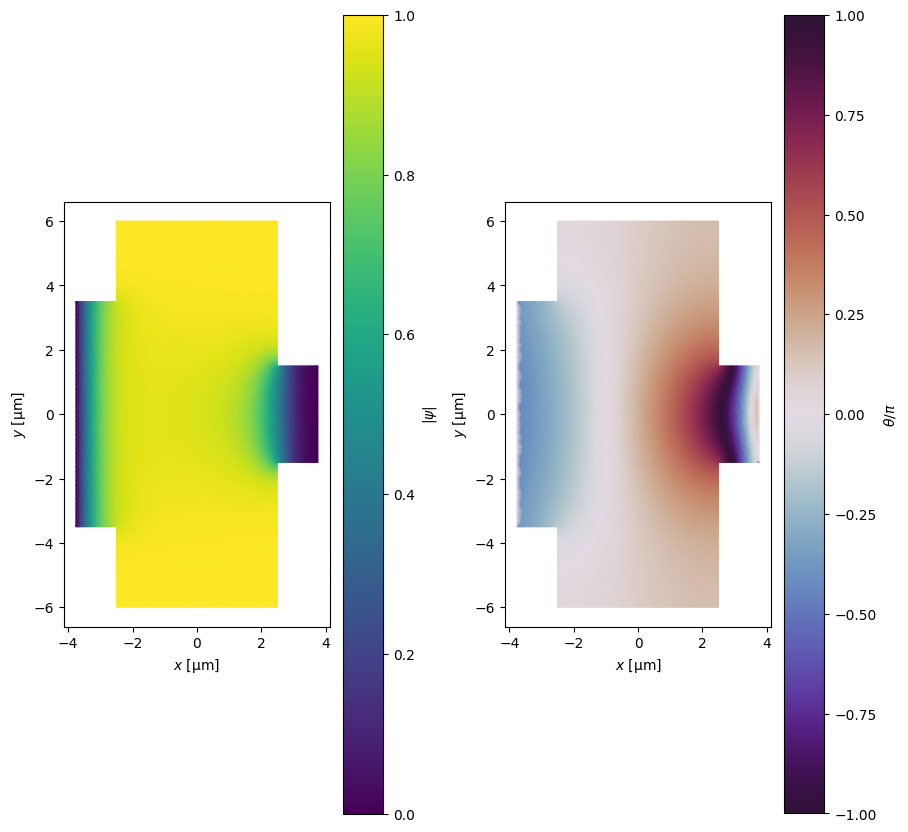

In [ ]:
# Create figure with adjusted spacing
fig, axes = plt.subplots(1, 2, figsize=(10, 4))  # Wider figure (10 inches width)
plt.subplots_adjust(wspace=0.4)  # Increase horizontal space between subplots
# Plot the currents
_ = zero_field_solution.plot_currents(ax=axes[0], streamplot=False)
_ = zero_field_solution.plot_currents(ax=axes[1])
# Evaluate sheet current density at cross-section
x = np.linspace(-width_x / 2, width_x / 2, 401)
y = 2 * np.ones_like(x)
cross_section = np.array([x, y]).T

plt.tight_layout()  # Automatically adjusts subplots to fit in figure
plt.show()
# Plot a snapshot of the order parameter in the middle of a phase slip
t0 = 155
zero_field_solution.solve_step = zero_field_solution.closest_solve_step(t0)
fig, axes = zero_field_solution.plot_order_parameter(figsize=(9, 10))
plt.show()

### 1.1)Constant Field for zero current

Simulating: 100%|██████████| 200/200 [01:18<00:00,  2.55tau/s ]


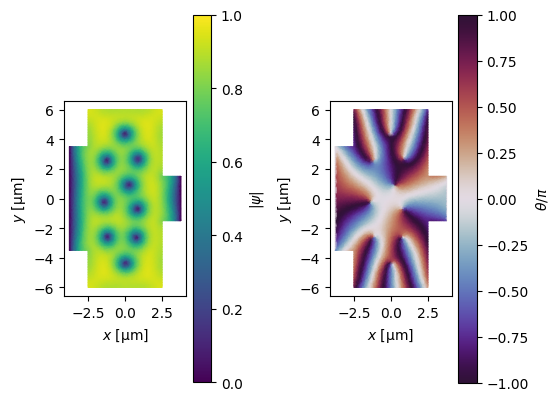

In [ ]:
zero_current_solution =  default_solution(device_fast, "weak-link-zero-field.h5",vector_potential=0.5)
fig, axes = zero_current_solution.plot_order_parameter(figsize=(5.5, 4))

### 1.2)varying fields for zero current

Simulating: 100%|██████████| 200/200 [01:13<00:00,  2.71tau/s ]


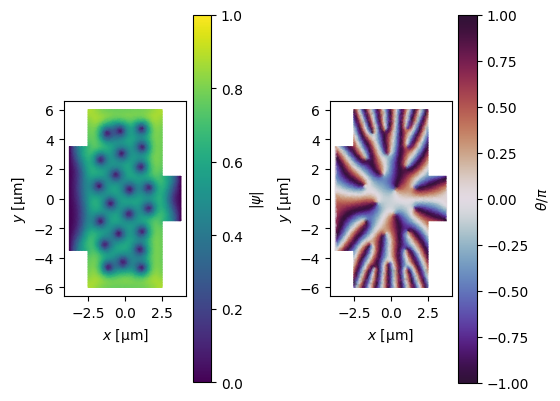

In [ ]:
zero_current_solution_2 =  default_solution(device_fast, "weak-link-zero-field.h5",vector_potential=1)
fig, axes = zero_current_solution_2.plot_order_parameter(figsize=(5.5, 4))

Simulating: 100%|██████████| 200/200 [01:18<00:00,  2.56tau/s ]


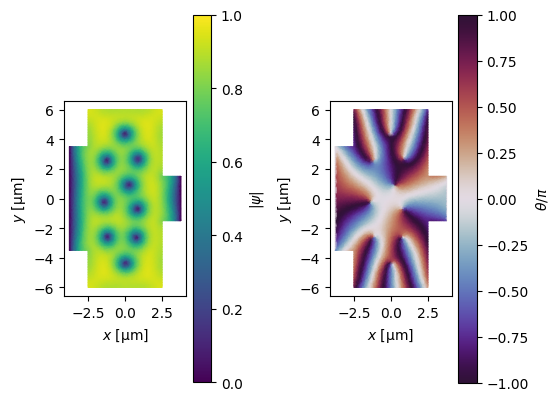

In [ ]:
zero_current_solution_3 =  default_solution(device_fast, "weak-link-zero-field.h5",vector_potential=0.5)
fig, axes = zero_current_solution_3.plot_order_parameter(figsize=(5.5, 4))

Simulating: 100%|██████████| 200/200 [01:02<00:00,  3.18tau/s ]


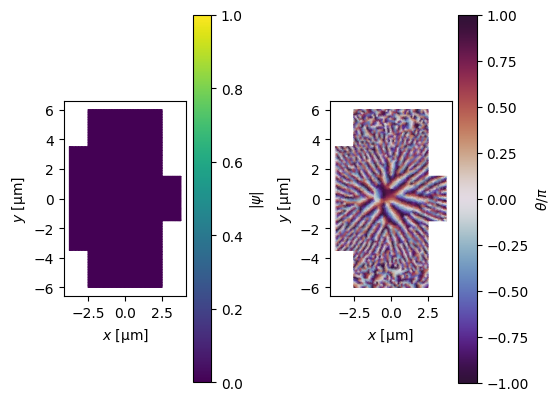

In [ ]:
zero_current_solution_4 =  default_solution(device_fast, "weak-link-zero-field.h5",vector_potential=3)
fig, axes = zero_current_solution_4.plot_order_parameter(figsize=(5.5, 4))

In [ ]:
#if MAKE_ANIMATIONS:
#    zero_current_solution_video = make_video_from_solution(
#        zero_current_solution,
#        quantities=["order_parameter", "phase", "scalar_potential"],
#        figsize=(6.5, 4),

#    )
#    display(zero_current_solution_video)

### 1.3)Fixed field, zero current with varying increments

  Malla creada: 3132 puntos


Simulating: 100%|█████████▉| 200/200 [01:33<00:00,  2.14tau/s ]


Text(0.5, 1.0, 'variación en y 1')

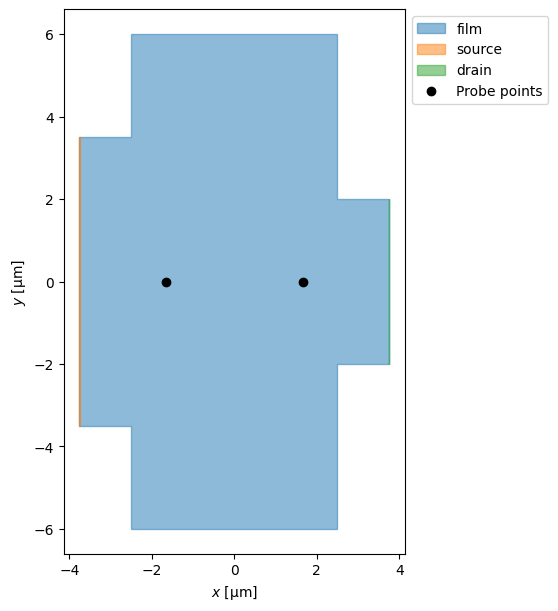

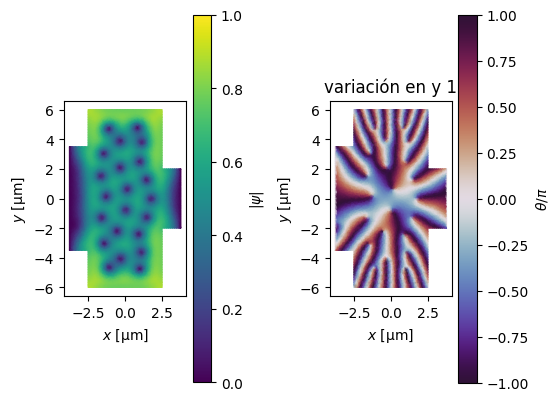

In [ ]:
device_1 = create_device(film_poly,half_geometry,layer,MAX_EDGE_LENGTH_IV,dimensions,translationx=displacement,incrementy=1)#h = 4
zero_current_solution_1 =  default_solution(device_1, "weak-link-zero-field.h5",vector_potential=1)
fig, axes = zero_current_solution_1.plot_order_parameter(figsize=(5.5, 4))
plt.title(f'variación en y {1}')

  Malla creada: 3387 puntos


Simulating: 100%|██████████| 200/200 [01:17<00:00,  2.57tau/s ]


Text(0.5, 1.0, 'variación en y 2')

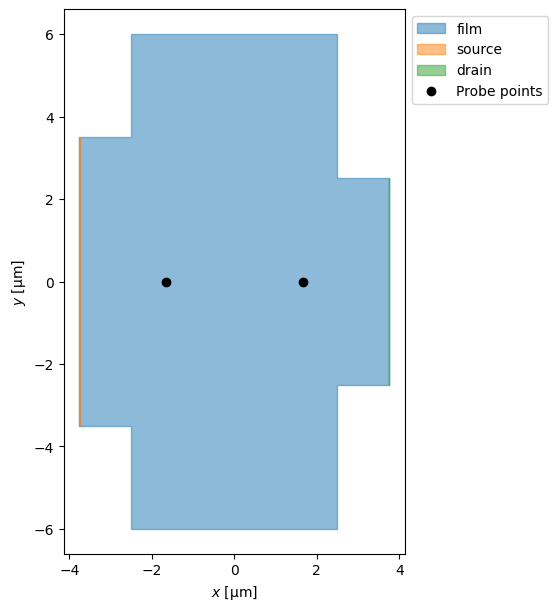

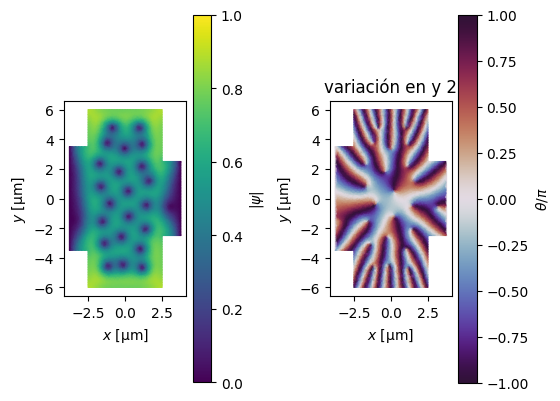

In [ ]:
device_2 = create_device(film_poly,half_geometry,layer,MAX_EDGE_LENGTH_IV,dimensions,translationx=displacement,incrementy=2)#h = 5
zero_current_solution_2 =  default_solution(device_2, "weak-link-zero-field.h5",vector_potential=1)
fig, axes = zero_current_solution_2.plot_order_parameter(figsize=(5.5, 4))
plt.title(f'variación en y {2}')

  Malla creada: 3148 puntos


Simulating: 100%|█████████▉| 200/200 [01:09<00:00,  2.89tau/s ]


Text(0.5, 1.0, 'variación en y 3')

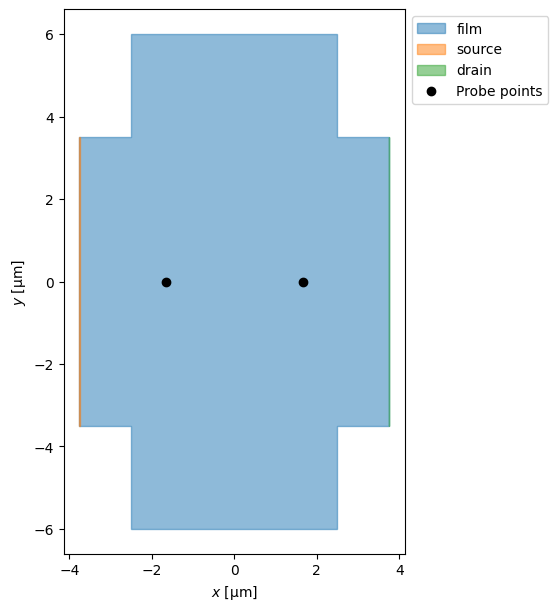

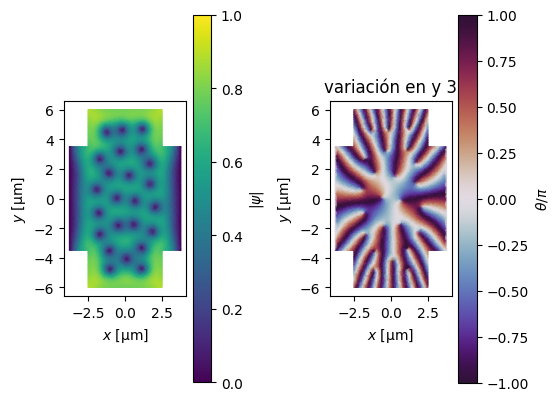

In [ ]:
device_3 = create_device(film_poly,half_geometry,layer,MAX_EDGE_LENGTH_IV,dimensions,translationx=displacement,incrementy=4)#h = y
zero_current_solution_3 =  default_solution(device_3, "weak-link-zero-field.h5",vector_potential=1)
fig, axes = zero_current_solution_3.plot_order_parameter(figsize=(5.5, 4))
plt.title(f'variación en y {3}')

## 2)Magnetization

Simulating: 100%|█████████▉| 200/200 [01:04<00:00,  3.09tau/s ]


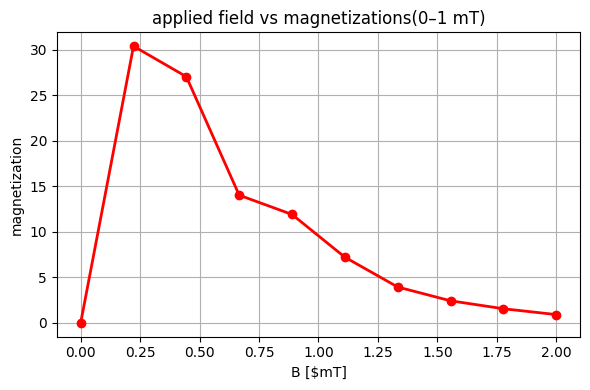

<Figure size 800x600 with 0 Axes>

In [ ]:

# =========================
# 2) Applied field
# =========================
applied_field = np.linspace(0.0, 2, 10)  # External field on mT (B)
field_solutions,magnetization = solve_field(device_fast,applied_field)
plot_info = plot_labels={"fig_name":"currents.jpg","title":f'applied field vs magnetizations(0–1 mT)',"x":"B [$mT]","y":"magnetization"}
plot_parameters(applied_field, -magnetization,color_applied="red",plot_labels = plot_info)

## 3) Zero field with varying currents

#### 3.1) Simulation with the default device

In [10]:
co= 70
ci= 80 # current_interval
steps = 40
#currents = np.linspace(-ci, ci, steps)
currents = np.linspace(co, ci, steps)
# from -20 to 20 µA, step


In [ ]:
voltages = current_application(device_fast, currents,B_field = 0.0)
actual_voltages = voltages
plot_info1 = {"fig_name":"currents.jpg","title":f'Curva Voltaje vs Corriente ({co}–{ci} µA)',"x":"Corriente $I$ [$\mu$A]","y":"Voltaje promedio $\\langle \Delta \\mu \\rangle$ [$V_0$]"}
plot_parameters(currents,actual_voltages,plot_info1)

<>:3: SyntaxWarning: invalid escape sequence '\m'
<>:3: SyntaxWarning: invalid escape sequence '\D'
<>:3: SyntaxWarning: invalid escape sequence '\m'
<>:3: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipython-input-3025633354.py:3: SyntaxWarning: invalid escape sequence '\m'
  plot_info1 = {"fig_name":"currents.jpg","title":f'Curva Voltaje vs Corriente ({co}–{ci} µA)',"x":"Corriente $I$ [$\mu$A]","y":"Voltaje promedio $\\langle \Delta \\mu \\rangle$ [$V_0$]"}
/tmp/ipython-input-3025633354.py:3: SyntaxWarning: invalid escape sequence '\D'
  plot_info1 = {"fig_name":"currents.jpg","title":f'Curva Voltaje vs Corriente ({co}–{ci} µA)',"x":"Corriente $I$ [$\mu$A]","y":"Voltaje promedio $\\langle \Delta \\mu \\rangle$ [$V_0$]"}
Simulating: 100%|█████████▉| 200/200 [01:14<00:00,  2.68tau/s ]


Simulating: 100%|██████████| 200/200 [01:15<00:00,  2.66tau/s ]


Simulating: 100%|█████████▉| 200/200 [01:17<00:00,  2.57tau/s ]


Simulating: 100%|██████████| 200/200 [01:17<00:00,  2.58tau/s ]


Simulating: 100%|██████████| 200/200 [01:16<00:00,  2.61tau/s ]


Simulating: 100%|█████████▉| 200/200 [01:15<00:00,  2.65tau/s ]


Simulating: 100%|█████████▉| 200/200 [01:23<00:00,  2.41tau/s ]


Simulating: 100%|█████████▉| 200/200 [01:13<00:00,  2.71tau/s ]


Simulating: 100%|█████████▉| 200/200 [01:14<00:00,  2.68tau/s ]


Simulating: 100%|█████████▉| 200/200 [01:16<00:00,  2.62tau/s ]


Simulating: 100%|█████████▉| 200/200 [01:17<00:00,  2.57tau/s ]


Simulating: 100%|██████████| 200/200 [01:18<00:00,  2.54tau/s ]


Simulating: 100%|█████████▉| 200/200 [01:15<00:00,  2.64tau/s ]


Simulating: 100%|█████████▉| 200/200 [01:17<00:00,  2.58tau/s ]


Simulating: 100%|█████████▉| 200/200 [01:17<00:00,  2.57tau/s ]


Simulating: 100%|██████████| 200/200 [01:17<00:00,  2.59tau/s ]


Simulating: 100%|██████████| 200/200 [01:17<00:00,  2.58tau/s ]


Simulating: 100%|█████████▉| 200/200 [01:19<00:00,  2.52tau/s ]


Simulating: 100%|█████████▉| 200/200 [01:18<00:00,  2.55tau/s ]


Simulating: 100%|█████████▉| 200/200 [01:15<00:00,  2.64tau/s ]


Simulating: 100%|██████████| 200/200 [01:16<00:00,  2.61tau/s ]


Simulating: 100%|██████████| 200/200 [01:15<00:00,  2.64tau/s ]


Simulating: 100%|█████████▉| 200/200 [01:19<00:00,  2.53tau/s ]


Simulating: 100%|██████████| 200/200 [01:16<00:00,  2.62tau/s ]


Simulating: 100%|█████████▉| 200/200 [01:28<00:00,  2.27tau/s ]


Simulating: 100%|█████████▉| 200/200 [01:14<00:00,  2.68tau/s ]


Simulating: 100%|██████████| 200/200 [01:18<00:00,  2.56tau/s ]


Simulating: 100%|█████████▉| 200/200 [01:17<00:00,  2.58tau/s ]


Simulating: 100%|█████████▉| 200/200 [01:17<00:00,  2.59tau/s ]


Simulating: 100%|█████████▉| 200/200 [01:16<00:00,  2.60tau/s ]


Simulating: 100%|█████████▉| 200/200 [01:18<00:00,  2.55tau/s ]


Simulating: 100%|█████████▉| 200/200 [01:17<00:00,  2.58tau/s ]


Simulating: 100%|█████████▉| 200/200 [01:19<00:00,  2.52tau/s ]


Simulating: 100%|██████████| 200/200 [01:19<00:00,  2.53tau/s ]


Simulating: 100%|█████████▉| 200/200 [01:14<00:00,  2.68tau/s ]


Simulating: 100%|██████████| 200/200 [01:18<00:00,  2.55tau/s ]


Simulating:  64%|██████▍   | 129/200 [00:50<00:25,  2.78tau/s ]

In [ ]:
actual_voltages = voltages
plot_info1 = {"fig_name":"currents.jpg","title":f'Curva Voltaje vs Corriente ({co}–{ci} µA)',"x":"Corriente $I$ [$\mu$A]","y":"Voltaje promedio $\\langle \Delta \\mu \\rangle$ [$V_0$]"}
plot_parameters(currents,actual_voltages,plot_info1)

### 4.2) Zero field with varying currents and device modifications

In [ ]:
print(f'widths: width_x:{width_x},width_x2:{width_x2},height_y:{height_y},height_y2:{height_y2},height_y2_altered:{3}' )


widths: width_x:5.0,width_x2:2.5,height_y:12.0,height_y2:7.0,height_y2_altered:3


In [ ]:
#height2 = de 4 a 7
io = 1
ifi = 4
size = ifi - io +1
voltages_arr = []
devices_arr = []
J = 0
def varying_increments():
    for h in range(io,ifi):
        deltay = h
        if h == 3:
            deltay = 4
        device_l  = create_device(half_geometry,MAX_EDGE_LENGTH_IV,incrementy=deltay)
        voltages =  current_application(device_l, currents,B_field = 1.0)
        devices_arr.append(device_l)
        voltages_arr.append(voltages)
        J+= 1
        print(f'progress: {np.round((J/size)*100,3)}')



In [ ]:
for j in range(0,2):
    plot_info2 = {"fig_name":"currents.jpg","title":f'Curva Voltaje vs Corriente variación de x: {j} (0–15 µA)',"x":"Corriente $I$ [$\mu$A]","y":"Voltaje promedio $\\langle \Delta \\mu \\rangle$ [$V_0$]"}

    plot_parameters(currents,voltages_arr[j],plot_info2)

<>:2: SyntaxWarning: invalid escape sequence '\m'
<>:2: SyntaxWarning: invalid escape sequence '\D'
<>:2: SyntaxWarning: invalid escape sequence '\m'
<>:2: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipython-input-2785454766.py:2: SyntaxWarning: invalid escape sequence '\m'
  plot_info2 = {"fig_name":"currents.jpg","title":f'Curva Voltaje vs Corriente variación de x: {j} (0–15 µA)',"x":"Corriente $I$ [$\mu$A]","y":"Voltaje promedio $\\langle \Delta \\mu \\rangle$ [$V_0$]"}
/tmp/ipython-input-2785454766.py:2: SyntaxWarning: invalid escape sequence '\D'
  plot_info2 = {"fig_name":"currents.jpg","title":f'Curva Voltaje vs Corriente variación de x: {j} (0–15 µA)',"x":"Corriente $I$ [$\mu$A]","y":"Voltaje promedio $\\langle \Delta \\mu \\rangle$ [$V_0$]"}


NameError: name 'plot_parameters' is not defined

# Default functions
the primary functions to create new variations of the previous sections are:
 * create_device(geometry_used,max_edge_length,increment=3,translationx=((width_x + width_x2 + STRIPE_LENGTH) / 2),translationy=0)
 * current_application(device,currents)
 * plot_parameters(p1,voltages,plot_labels,plot_type="plot",color_applied="teal")